In [1]:
# Import libraries.
using Turing, StatsPlots, Random, Memoization

## The model of agent as universal Probalistic Model
### gets some parmeters:
<ul>
    <li> opponent agent - representation of our belief on the opponent model (Turing.jl model)
    <li> my history - list of all moves this player done (At this point unused)
    <li> opponent history - list of all moves the opponent done, used to estimate a prior on the moves
    <li> depth - the depth we want the agent will dive modeling the mind of opponent agent
</ul>        

In [2]:
N = 10000
INFALG = IS()
PRIOR_POLICY = [1,1,1]
PDIRAC = 0.95

0.95

In [18]:
function winning(opp_move)
    best_moves = Dict(1 => 2, 2 => 3, 3 => 1)
    move = best_moves[opp_move]
    return move
end

winning (generic function with 1 method)

In [43]:
@model function agent(opponent_chn, opponent_history, opp_prior_policy = [1,1,1], depth = 1)
    beta_opp ~ Dirichlet(opp_prior_policy) #prior
    if depth == 0
        for i in 1:length(opponent_history)
            opponent_history[i] ~ Categorical(beta_opp) # observe
        end
        next_opp_move ~ Categorical(beta_opp) # sample
    end
    if depth > 0
        weights = exp.(opponent_chn[:lp][:, 1])
        idx ~ Categorical(weights/sum(weights))
        opp_move_sample = opponent_chn[:my_move][idx, 1]
        
        # init alternative way to Dirac distribution
        complete_p_dirac = (1 - PDIRAC) / 2
        phi = fill(complete_p_dirac, 3)
        phi[convert(Int, opp_move_sample)] = PDIRAC
        
        next_opp_move ~ Categorical(phi) # observe
    end
    winning_move = winning(next_opp_move)
    
    # init alternative way to Dirac distribution
    complete_p_dirac = (1 - PDIRAC) / 2
    phi = fill(complete_p_dirac, 3)
    phi[convert(Int,winning_move)] = PDIRAC
    
    my_move ~ Categorical(phi) # Dirac(next_opp_move) / observe(next_opponent_move, infered_opponent_move)
end

agent (generic function with 3 methods)

In [33]:
# Plot the results
function plotChn(chn)
    histogram(chn[:my_move], weights=exp.(chn[:lp]), normalize=:probability)
end

plotChn (generic function with 1 method)

In [36]:
function run_two_agents_theory_of_mind(first_model, second_model, first_player_history, second_player_history ,depth)
    second_chn_i = []
    first_chn_i = []
    for i in 0:depth
        first_chn_i = sample(first_model(second_chn_i, second_player_history, PRIOR_POLICY, i),  INFALG, N)
        second_chn_i = sample(second_model(first_chn_i, first_player_history, PRIOR_POLICY, i), INFALG, N)
    end
    display(second_chn_i)
    plotChn(second_chn_i)
end

run_two_agents_theory_of_mind (generic function with 1 method)

## Depth 0

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (10000×6×1 Array{Float64,3}):

Log evidence      = -9.541008354946573
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters      mean       std   naive_se      mcse          ess      rha ⋯
         Symbol   Float64   Float64    Float64   Float64      Float64   Float6 ⋯

    beta_opp[1]    0.3330    0.2363     0.0024    0.0026    9842.8425    1.000 ⋯
    beta_opp[2]    0.3313    0.2350     0.0023    0.0025   10197.0836    1.000 ⋯
    beta_opp[3]    0.3357    0.2374     0.0024    0.0026   10157.9377    0.999 ⋯
        my_move    1.9931    0.8147     0.0081    0.0075    9990.2085    1.000 ⋯
  next_opp_move    1.9987    0.8208     0.0082    0.0073   10078.9010    0.999 ⋯
                                                                1 column omitted

Quantiles
     parameters      2.5%    

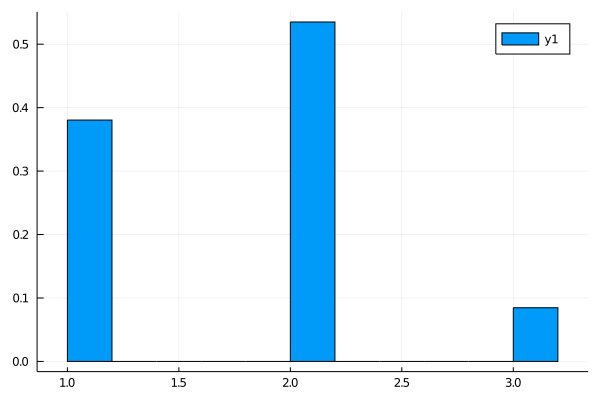

In [38]:
run_two_agents_theory_of_mind(agent, agent, [1,3,1,3,1,1,3,1,3,1] , [1,1,1,1,1,1,1,1,1,1], 0)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


Chains MCMC chain (10000×6×1 Array{Float64,3}):

Log evidence      = -4.192372481960167
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters      mean       std   naive_se      mcse          ess      rha ⋯
         Symbol   Float64   Float64    Float64   Float64      Float64   Float6 ⋯

    beta_opp[1]    0.3376    0.2346     0.0023    0.0025    9362.6389    1.000 ⋯
    beta_opp[2]    0.3325    0.2363     0.0024    0.0024    9944.2036    1.000 ⋯
    beta_opp[3]    0.3299    0.2366     0.0024    0.0023   10116.4918    0.999 ⋯
        my_move    2.0066    0.8107     0.0081    0.0078   10038.9474    1.000 ⋯
  next_opp_move    1.9844    0.8177     0.0082    0.0082    9640.2665    0.999 ⋯
                                                                1 column omitted

Quantiles
     parameters      2.5%    

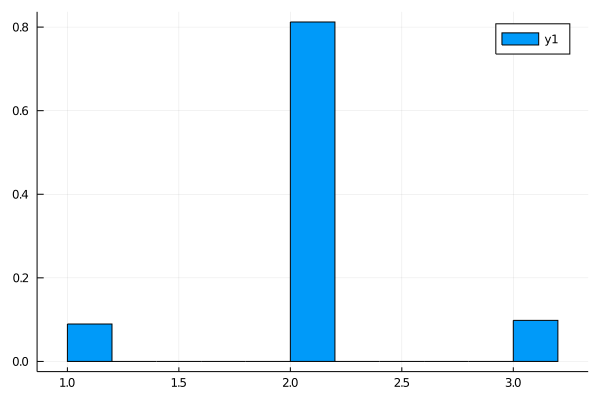

In [39]:
run_two_agents_theory_of_mind(agent, agent, [1,1,1,1,1,1,1,1,1,1], [1,3,1,3,1,1,3,1,3,1], 0)

## Depth 3

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04


Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], idx, my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters        mean         std   naive_se      mcse          ess      ⋯
         Symbol     Float64     Float64    Float64   Float64      Float64   Fl ⋯

    beta_opp[1]      0.3324      0.2353     0.0024    0.0026   10055.9950    0 ⋯
    beta_opp[2]      0.3321      0.2373     0.0024    0.0028    9588.3724    0 ⋯
    beta_opp[3]      0.3355      0.2376     0.0024    0.0025    9759.3809    0 ⋯
            idx   5016.7148   2889.1696    28.8917   24.2434    9870.2626    1 ⋯
        my_move      1.9117      0.7614     0.0076    0.0074    9588.1120    0 ⋯
  next_opp_move      1.9220      0.8675     0.0087    0.0084   10181.8757    0 ⋯
                                                  

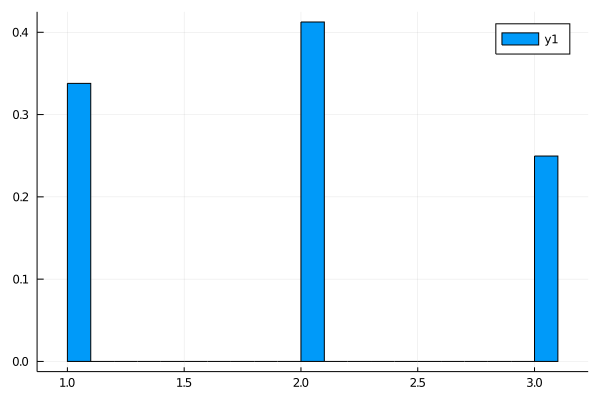

In [44]:
run_two_agents_theory_of_mind(agent, agent, [1,3,1,3,1,1,3,1,3,1] , [1,1,1,1,1,1,1,1,1,1], 3)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06


Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], idx, my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters        mean         std   naive_se      mcse          ess      ⋯
         Symbol     Float64     Float64    Float64   Float64      Float64   Fl ⋯

    beta_opp[1]      0.3295      0.2344     0.0023    0.0024    9372.2192    0 ⋯
    beta_opp[2]      0.3357      0.2368     0.0024    0.0023    9890.8770    0 ⋯
    beta_opp[3]      0.3348      0.2360     0.0024    0.0024    9808.1364    0 ⋯
            idx   4990.8934   2883.4820    28.8348   26.7505    9914.2951    0 ⋯
        my_move      2.0063      0.6770     0.0068    0.0066   10278.3695    1 ⋯
  next_opp_move      1.6571      0.8118     0.0081    0.0071   10239.0708    1 ⋯
                                                  

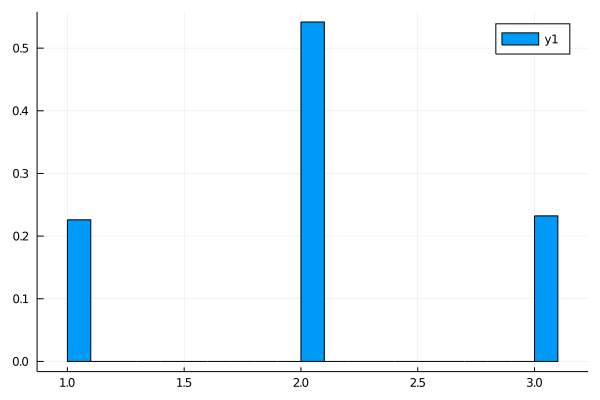

In [45]:
run_two_agents_theory_of_mind(agent, agent, [1,1,1,1,1,1,1,1,1,1], [1,3,1,3,1,1,3,1,3,1], 3)

## Depth 10

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:08
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:14
Sampling: 100%|█████████████████████████████████████████| Time: 

Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], idx, my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters        mean         std   naive_se      mcse          ess      ⋯
         Symbol     Float64     Float64    Float64   Float64      Float64   Fl ⋯

    beta_opp[1]      0.3351      0.2360     0.0024    0.0024    9379.1788    1 ⋯
    beta_opp[2]      0.3315      0.2354     0.0024    0.0025    9937.9141    0 ⋯
    beta_opp[3]      0.3334      0.2329     0.0023    0.0021   10043.1170    1 ⋯
            idx   5036.1685   2876.2043    28.7620   29.3882    9765.0317    0 ⋯
        my_move      2.0061      0.8286     0.0083    0.0090    9899.2391    0 ⋯
  next_opp_move      2.0280      0.8076     0.0081    0.0082    9709.9625    0 ⋯
                                                  

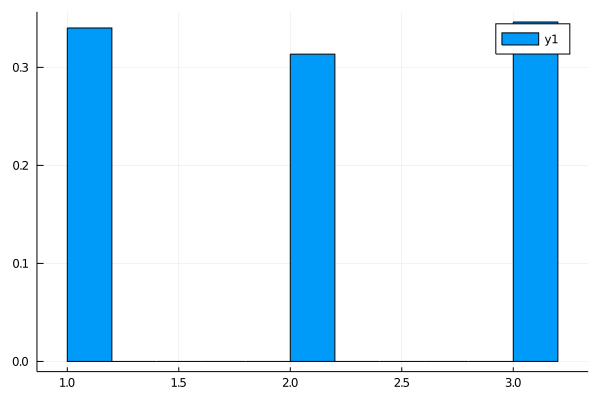

In [46]:
run_two_agents_theory_of_mind(agent, agent, [1,3,1,3,1,1,3,1,3,1] , [1,1,1,1,1,1,1,1,1,1], 10)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 

Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], idx, my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters        mean         std   naive_se      mcse          ess      ⋯
         Symbol     Float64     Float64    Float64   Float64      Float64   Fl ⋯

    beta_opp[1]      0.3360      0.2344     0.0023    0.0022    9940.4604    1 ⋯
    beta_opp[2]      0.3301      0.2334     0.0023    0.0021   10111.3338    1 ⋯
    beta_opp[3]      0.3339      0.2344     0.0023    0.0023    9765.9697    0 ⋯
            idx   4974.4486   2875.5641    28.7556   30.2358   10105.5160    1 ⋯
        my_move      1.9475      0.8260     0.0083    0.0074    9971.4864    1 ⋯
  next_opp_move      2.0585      0.8270     0.0083    0.0083    9902.7896    0 ⋯
                                                  

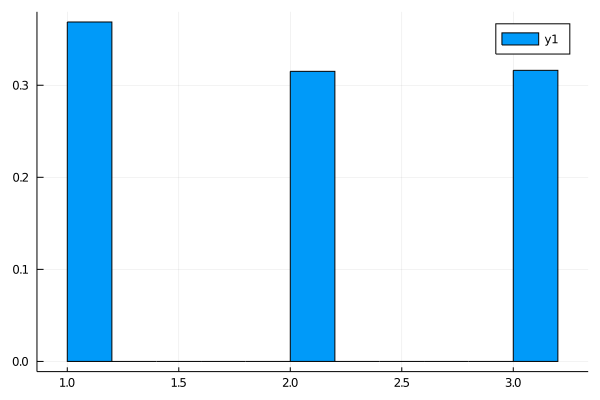

In [47]:
run_two_agents_theory_of_mind(agent, agent, [1,1,1,1,1,1,1,1,1,1], [1,3,1,3,1,1,3,1,3,1], 10)

## Depth 20

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:06
Sampling: 100%|█████████████████████████████████████████| Time: 

Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], idx, my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters        mean         std   naive_se      mcse          ess      ⋯
         Symbol     Float64     Float64    Float64   Float64      Float64   Fl ⋯

    beta_opp[1]      0.3313      0.2342     0.0023    0.0022    9842.8910    1 ⋯
    beta_opp[2]      0.3347      0.2357     0.0024    0.0024    9879.8411    1 ⋯
    beta_opp[3]      0.3340      0.2327     0.0023    0.0023    9927.6973    1 ⋯
            idx   5022.2347   2902.4192    29.0242   30.7549    9977.2315    1 ⋯
        my_move      2.0229      0.8092     0.0081    0.0081   10034.0576    1 ⋯
  next_opp_move      1.9660      0.8131     0.0081    0.0078   10255.1795    1 ⋯
                                                  

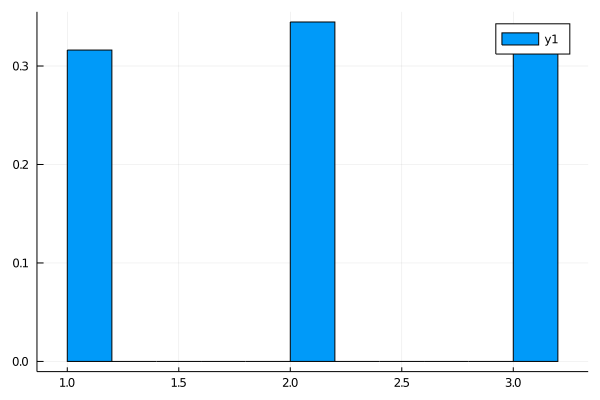

In [48]:
run_two_agents_theory_of_mind(agent, agent, [1,3,1,3,1,1,3,1,3,1] , [1,1,1,1,1,1,1,1,1,1], 20)

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:04
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:03
Sampling: 100%|█████████████████████████████████████████| Time: 

Chains MCMC chain (10000×7×1 Array{Float64,3}):

Log evidence      = 0.0
Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = beta_opp[1], beta_opp[2], beta_opp[3], idx, my_move, next_opp_move
internals         = lp

Summary Statistics
     parameters        mean         std   naive_se      mcse          ess      ⋯
         Symbol     Float64     Float64    Float64   Float64      Float64   Fl ⋯

    beta_opp[1]      0.3314      0.2374     0.0024    0.0020    9701.3161    0 ⋯
    beta_opp[2]      0.3338      0.2393     0.0024    0.0024    9874.1144    1 ⋯
    beta_opp[3]      0.3348      0.2397     0.0024    0.0024    9466.1561    1 ⋯
            idx   4986.7343   2888.8738    28.8887   28.5716    9799.7753    1 ⋯
        my_move      2.0189      0.8223     0.0082    0.0075    9974.5919    1 ⋯
  next_opp_move      2.0062      0.8096     0.0081    0.0070   10362.0550    1 ⋯
                                                  

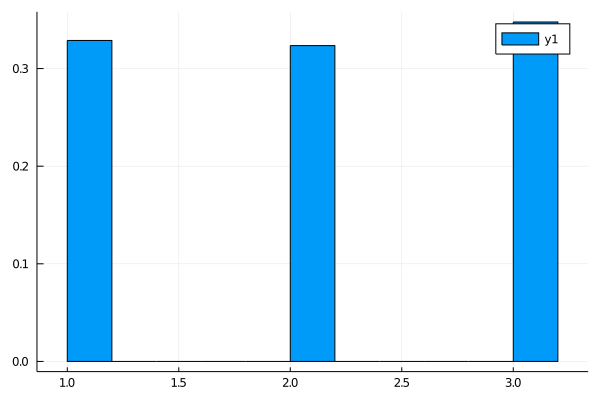

In [49]:
run_two_agents_theory_of_mind(agent, agent, [1,1,1,1,1,1,1,1,1,1], [1,3,1,3,1,1,3,1,3,1], 20)